### Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

### Reading the Dataset

In [2]:
df = pd.read_csv('cell_samples.csv')
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [4]:
df['Class'].value_counts()

2    458
4    241
Name: Class, dtype: int64

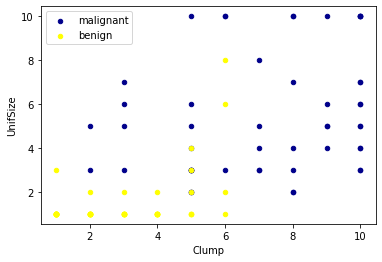

In [5]:
ax = df[df['Class'] == 4][:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant')
df[df['Class'] == 2][:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax)
plt.show()

### Data Pre-Processing and Selection

In [8]:
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [11]:
X = np.asarray(df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']])
df['Class'] = df['Class'].astype('int')
y = np.asarray(df['Class'])

print(X[:5])
print(y[:5])

[[ 5  1  1  1  2  1  3  1  1]
 [ 5  4  4  5  7 10  3  2  1]
 [ 3  1  1  1  2  2  3  1  1]
 [ 6  8  8  1  3  4  3  7  1]
 [ 4  1  1  3  2  1  3  1  1]]
[2 2 2 2 2]


### Splitting the Dataset into Train and Test sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


### Modeling

Using Radial Basis Function (RBF) for kernelling:

In [13]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
yhat[:5]

array([2, 4, 2, 4, 2])

### Evaluation

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix without normalization
[[85  5]
 [ 0 47]]


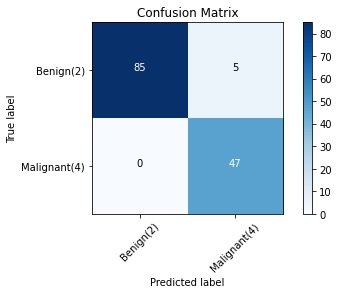

In [20]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2, 4])
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)', 'Malignant(4)'], normalize=False, title='Confusion Matrix')

#### f1 score

In [16]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.9639038982104676

#### jaccard index

In [17]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, pos_label=2)

0.9444444444444444

### Rebuilding the Model with a Linear kernel

In [18]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train)
yhat2 = clf2.predict(X_test)

print('Averafe f1-score: %.4f' % f1_score(y_test, yhat2, average='weighted'))
print('Jaccard score: %.4f' % jaccard_score(y_test, yhat2, pos_label=2))

Averafe f1-score: 0.9639
Jaccard score: 0.9444
